In [2]:
cd /content/drive/MyDrive/[Projects]/AI Hub/Pose Detection 기반 실시간 낙상 감지 시스템 개발/Data

/content/drive/MyDrive/[Projects]/AI Hub/Pose Detection 기반 실시간 낙상 감지 시스템 개발/Data


In [3]:
import random

def fix_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
import pandas as pd
import numpy as np

def load_csv(csv_path):
    df = pd.read_csv(csv_path)
    df.sort_values(["file", "frame"], inplace=True)
    return df

def make_sequences(df, window_size=10, step=1):
    x, y = [], []

    joint_count = 17
    channels = 3  # x,y,score

    feature_cols = []
    for j in range(joint_count):
        for c in ["x","y","score"]:
            feature_cols.append(f"{j}_{c}")

    # rename raw data → 0_x, 0_y, 0_score, ...
    rename_map = {}
    k = 0
    for i, joint in enumerate([
        "nose","left_eye","right_eye",
        "left_ear","right_ear",
        "left_shoulder","right_shoulder",
        "left_elbow","right_elbow",
        "left_wrist","right_wrist",
        "left_hip","right_hip",
        "left_knee","right_knee",
        "left_ankle","right_ankle",
    ]):
        rename_map[f"{joint}_x"] = f"{i}_x"
        rename_map[f"{joint}_y"] = f"{i}_y"
        rename_map[f"{joint}_score"] = f"{i}_score"

    df = df.rename(columns=rename_map)

    for file, group in df.groupby("file"):
        labels = group["label"].values
        data = group[feature_cols].values.reshape(-1, joint_count, channels)

        for i in range(0, len(data)-window_size+1, step):
            seq = data[i:i+window_size]              # (T, 17, 3)
            seq = np.transpose(seq, (2,1,0))         # (3,17,T)

            target = 1 if np.sum(labels[i:i+window_size]) > 0 else 0
            x.append(seq)
            y.append(target)

    x = np.array(x)
    y = np.array(y)

    return x, y

In [5]:
import torch
import numpy as np

# COCO 17 edges
coco_pairs = [
    (0,1),(1,3),(0,2),(2,4),     # face
    (5,7),(7,9),(6,8),(8,10),    # arms
    (11,13),(13,15),(12,14),(14,16),  # legs
    (5,6),(11,12),(5,11),(6,12),(1,5),(2,6)  # torso
]

A = np.zeros((17,17))
for i,j in coco_pairs:
    A[i,j] = 1
    A[j,i] = 1

# normalize
deg = np.sum(A, axis=1, keepdims=True)
A = A / deg
A = np.nan_to_num(A)

A = torch.tensor(A, dtype=torch.float32)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class STGCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, A, stride=1, kernel_size=9):
        super().__init__()
        self.A = A
        self.gcn = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.tcn = nn.Conv2d(out_channels, out_channels, kernel_size=(1,kernel_size),
                             padding=(0, kernel_size//2), stride=(1,stride), bias=False)
        self.bn = nn.BatchNorm2d(out_channels)

        self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=(1,stride)) \
                        if in_channels != out_channels or stride != 1 else nn.Identity()

    def forward(self, x):
        res = self.residual(x)
        # spatial graph convolution
        x = torch.einsum("vw, bcvt -> bcvt", self.A, x)
        x = self.gcn(x)
        x = F.relu(self.bn(x))
        # temporal convolution
        x = self.tcn(x)
        x = self.bn(x)
        return F.relu(x + res)

class STGCN(nn.Module):
    def __init__(self, A, num_classes=1):
        super().__init__()
        self.layer1 = STGCNBlock(3, 64, A)
        self.layer2 = STGCNBlock(64, 128, A, stride=2)
        self.layer3 = STGCNBlock(128, 256, A, stride=2)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        # x: (N, C, T, V)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.mean(dim=[2,3])  # temporal + spatial pooling
        return self.fc(x)

In [7]:
from torch.utils.data import TensorDataset, DataLoader

def train_model(x, y, x_val, y_val, A, epochs=10, batch_size=64, lr=1e-3):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = STGCN(A.to(device)).to(device)

    pos = y.sum()
    neg = len(y) - pos
    pw  = neg / pos
    pos_weight = torch.tensor([pw], device=device)

    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optim = torch.optim.Adam(model.parameters(), lr=lr)

    train_ds = TensorDataset(
        torch.tensor(x).float(),
        torch.tensor(y).float()
    )
    val_ds = TensorDataset(
        torch.tensor(x_val).float(),
        torch.tensor(y_val).float()
    )

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for seq, label in train_loader:
            seq = seq.to(device)
            label = label.to(device)

            logits = model(seq).view(-1)
            loss = loss_fn(logits, label)

            optim.zero_grad()
            loss.backward()
            optim.step()
            total_loss += loss.item()

        print(f'[Epoch {epoch+1}] loss = {total_loss/len(train_loader):.4f}')

    return model

In [8]:
from sklearn.metrics import precision_recall_curve

def find_best_threshold(model, x_val, y_val):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()

    probs = []

    with torch.no_grad():
        for seq in x_val:
            seq = torch.tensor(seq).float().unsqueeze(0).to(device)
            logit = model(seq)
            prob = torch.sigmoid(logit).item()
            probs.append(prob)

    probs = np.array(probs)

    prec, rec, ths = precision_recall_curve(y_val, probs)

    best_f1 = 0
    best_th = 0.5

    for p, r, t in zip(prec, rec, ths):
        f1 = 2*p*r / (p+r+1e-8)
        if f1 > best_f1:
            best_f1 = f1
            best_th = t

    return best_th, best_f1

In [9]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate(model, x_val, y_val, threshold):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()

    preds = []
    probs = []

    ds = TensorDataset(
        torch.tensor(x_val).float(),
        torch.tensor(y_val).float()
    )
    loader = DataLoader(ds, batch_size=64, shuffle=False)

    with torch.no_grad():
        for seq, label in loader:
            seq = seq.to(device)

            logits = model(seq).squeeze()
            prob = torch.sigmoid(logits)

            probs.extend(prob.cpu().numpy())
            preds.extend((prob > threshold).cpu().numpy())

    preds = np.array(preds)
    y_val = np.array(y_val)

    cm = confusion_matrix(y_val, preds)
    precision = precision_score(y_val, preds, zero_division=0)
    recall    = recall_score(y_val, preds, zero_division=0)
    f1        = f1_score(y_val, preds, zero_division=0)

    print("\n📌 CONFUSION MATRIX")
    print(cm)
    print(f"\nPrecision = {precision:.4f}")
    print(f"Recall    = {recall:.4f}")
    print(f"F1        = {f1:.4f}")

    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidth=.5)
    plt.show()

    return f1, precision, recall, cm

In [10]:
train_df = load_csv("output_train.csv")
val_df   = load_csv("output_val.csv")

In [11]:
train_df.head()

,file,frame,label,nose_x,nose_y,nose_score,left_eye_x,left_eye_y,left_eye_score,right_eye_x,...,left_knee_score,right_knee_x,right_knee_y,right_knee_score,left_ankle_x,left_ankle_y,left_ankle_score,right_ankle_x,right_ankle_y,right_ankle_score
201048,00002_H_A_N_C1.mp4,0,0,442.274292,302.780212,0.961438,447.320007,294.638428,0.828017,431.255310,...,0.995945,420.807007,516.382324,0.997787,554.010925,628.323120,0.979250,420.376526,659.532959,0.985658
201049,00002_H_A_N_C1.mp4,1,0,440.839233,303.524109,0.964443,446.424835,295.297272,0.850829,429.885437,...,0.995983,420.356689,517.684387,0.997665,555.401550,626.958191,0.980147,420.532806,659.837646,0.985645
201050,00002_H_A_N_C1.mp4,2,0,441.611084,303.199280,0.963709,447.098206,294.915924,0.846917,430.466675,...,0.996007,420.453857,517.431763,0.997671,555.535522,627.419189,0.980225,420.159454,658.446411,0.985696
201051,00002_H_A_N_C1.mp4,3,0,442.712311,306.896973,0.963096,447.724915,298.113525,0.831183,431.603394,...,0.996252,420.279419,517.739868,0.997923,555.691895,627.266602,0.980635,420.072571,656.829224,0.986490
201052,00002_H_A_N_C1.mp4,4,0,446.509247,303.585266,0.965001,449.876373,295.684540,0.762596,435.906067,...,0.997334,422.029663,520.645996,0.998919,552.713440,626.840332,0.985617,423.048767,662.530396,0.991652


In [12]:
val_df.head()

,file,frame,label,nose_x,nose_y,nose_score,left_eye_x,left_eye_y,left_eye_score,right_eye_x,...,left_knee_score,right_knee_x,right_knee_y,right_knee_score,left_ankle_x,left_ankle_y,left_ankle_score,right_ankle_x,right_ankle_y,right_ankle_score
1000,00001_H_A_SY_C1.mp4,0,0,432.507782,301.897675,0.965829,440.708374,293.584564,0.884790,423.292175,...,0.997029,410.709625,464.343903,0.996638,536.149414,632.925842,0.989198,448.847687,658.614075,0.987186
1001,00001_H_A_SY_C1.mp4,1,0,432.910187,304.123962,0.966320,441.175568,295.566284,0.880655,423.673309,...,0.997095,411.179382,466.708618,0.996904,536.719482,632.899475,0.989341,448.511200,658.298096,0.987857
1002,00001_H_A_SY_C1.mp4,2,0,433.168152,305.085907,0.963752,441.193665,296.166718,0.869938,423.771057,...,0.997093,411.892151,466.767395,0.996901,537.091675,632.759094,0.989379,449.215179,658.937134,0.987887
1003,00001_H_A_SY_C1.mp4,3,0,433.140137,305.882416,0.963503,441.051361,296.971436,0.866934,423.764404,...,0.997141,411.414917,467.523193,0.997058,537.204590,632.072815,0.989498,449.638275,659.788635,0.988305
1004,00001_H_A_SY_C1.mp4,4,0,433.314209,306.045380,0.963903,441.114166,296.993317,0.863276,423.847351,...,0.997167,411.140594,467.391479,0.997144,536.405212,632.130249,0.989165,449.199982,659.140015,0.988118


In [13]:
train_df = train_df.interpolate().fillna(0)
val_df = val_df.interpolate(). fillna(0)

/tmp/ipython-input-1155671703.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  train_df = train_df.interpolate().fillna(0)
/tmp/ipython-input-1155671703.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  val_df = val_df.interpolate(). fillna(0)


In [178]:
window_to_model = {}
window_to_threshold = {}
results = []

(377848, 3, 17, 10) (377848,)
[Epoch 1] loss = 0.8179
[Epoch 2] loss = 0.6922
[Epoch 3] loss = 0.6651
[Epoch 4] loss = 0.6507
[Epoch 5] loss = 0.6417
[Epoch 6] loss = 0.6386
[Epoch 7] loss = 0.6270
[Epoch 8] loss = 0.6209
[Epoch 9] loss = 0.6163
[Epoch 10] loss = 0.6115
best threshold = 0.43968722224235535

📌 CONFUSION MATRIX
[[46981  1299]
 [ 4218  1374]]

Precision = 0.5140
Recall    = 0.2457
F1        = 0.3325


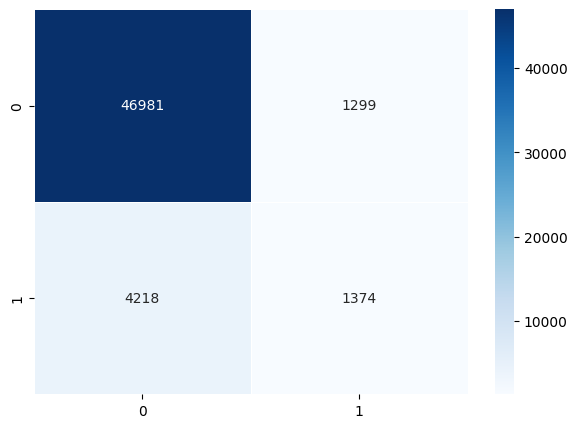

In [179]:
WINDOW = 10

fix_seed(42)

x_train, y_train = make_sequences(train_df, window_size=WINDOW)
x_val, y_val     = make_sequences(val_df, window_size=WINDOW)

print(x_train.shape, y_train.shape)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_10 = train_model(x_train, y_train, x_val, y_val, A=A)

best_th_10, best_f1 = find_best_threshold(model_10, x_val, y_val)
print("best threshold =", best_th_10)

window_to_model[WINDOW] = model_10
window_to_threshold[WINDOW] = best_th_10

f1, precision, recall, cm = evaluate(model_10, x_val, y_val, threshold=best_th_10)

results.append({
    'Window size': WINDOW,
    'F1-Score': f1,
    'Precision': precision,
    'Recall': recall
})

[Epoch 1] loss = 0.7325
[Epoch 2] loss = 0.6165
[Epoch 3] loss = 0.5895
[Epoch 4] loss = 0.5703
[Epoch 5] loss = 0.5574
[Epoch 6] loss = 0.5441
[Epoch 7] loss = 0.5324
[Epoch 8] loss = 0.5217
[Epoch 9] loss = 0.5140
[Epoch 10] loss = 0.5035
best threshold = 0.6373892426490784

📌 CONFUSION MATRIX
[[35175  4393]
 [ 5138  3246]]

Precision = 0.4249
Recall    = 0.3872
F1        = 0.4052


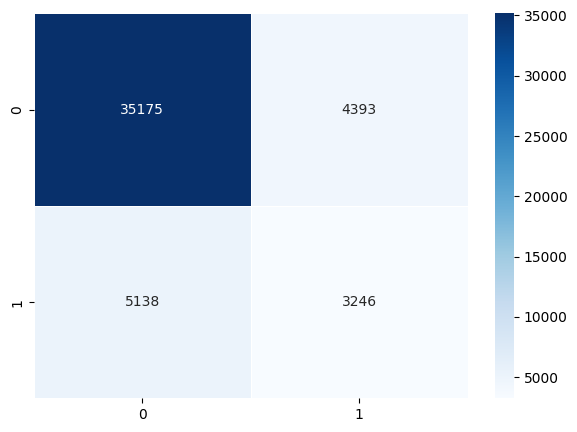

In [180]:
WINDOW = 20

fix_seed(42)

x_train, y_train = make_sequences(train_df, window_size=WINDOW)
x_val, y_val     = make_sequences(val_df, window_size=WINDOW)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_20 = train_model(x_train, y_train, x_val, y_val, A=A)

best_th_20, best_f1 = find_best_threshold(model_20, x_val, y_val)
print("best threshold =", best_th_20)

window_to_model[WINDOW] = model_20
window_to_threshold[WINDOW] = best_th_20

f1, precision, recall, cm = evaluate(model_20, x_val, y_val, threshold=best_th_20)
results.append({
    'Window size': WINDOW,
    'F1-Score': f1,
    'Precision': precision,
    'Recall': recall
})

[Epoch 1] loss = 0.6561
[Epoch 2] loss = 0.5342
[Epoch 3] loss = 0.5100
[Epoch 4] loss = 0.4934
[Epoch 5] loss = 0.4785
[Epoch 6] loss = 0.4678
[Epoch 7] loss = 0.4556
[Epoch 8] loss = 0.4451
[Epoch 9] loss = 0.4387
[Epoch 10] loss = 0.4309
best threshold = 0.3650248944759369

📌 CONFUSION MATRIX
[[ 2569 28367]
 [  598 10498]]

Precision = 0.2701
Recall    = 0.9461
F1        = 0.4202


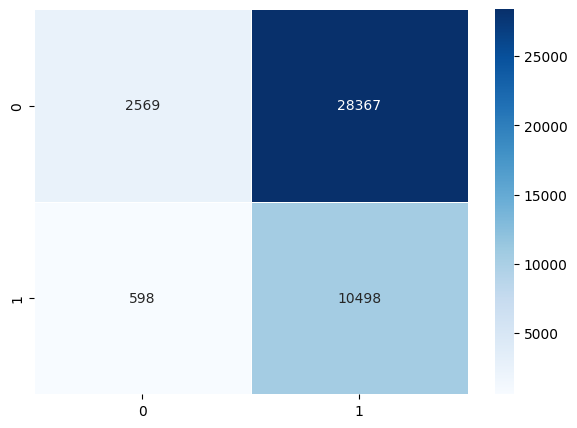

In [181]:
WINDOW = 30

fix_seed(42)

x_train, y_train = make_sequences(train_df, window_size=WINDOW)
x_val, y_val     = make_sequences(val_df, window_size=WINDOW)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_30 = train_model(x_train, y_train, x_val, y_val, A=A)

best_th_30, best_f1 = find_best_threshold(model_30, x_val, y_val)
print("best threshold =", best_th_30)

window_to_model[WINDOW] = model_30
window_to_threshold[WINDOW] = best_th_30

f1, precision, recall, cm = evaluate(model_30, x_val, y_val, threshold=best_th_30)
results.append({
    'Window size': WINDOW,
    'F1-Score': f1,
    'Precision': precision,
    'Recall': recall
})

[Epoch 1] loss = 0.5580
[Epoch 2] loss = 0.4178
[Epoch 3] loss = 0.3895
[Epoch 4] loss = 0.3719
[Epoch 5] loss = 0.3564
[Epoch 6] loss = 0.3436
[Epoch 7] loss = 0.3317
[Epoch 8] loss = 0.3171
[Epoch 9] loss = 0.3083
[Epoch 10] loss = 0.2978
best threshold = 0.007631242740899324

📌 CONFUSION MATRIX
[[    3 22653]
 [    0 13456]]

Precision = 0.3726
Recall    = 1.0000
F1        = 0.5430


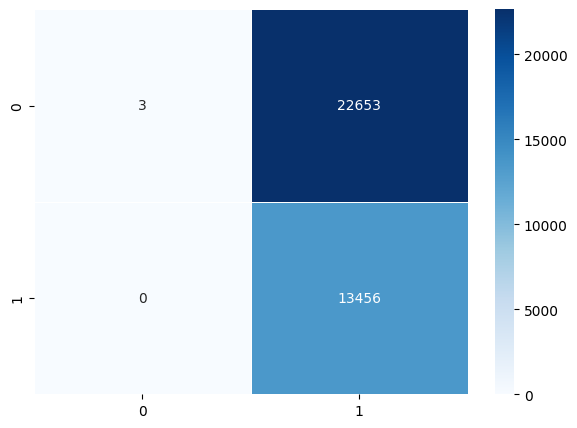

In [182]:
WINDOW = 40

fix_seed(42)

x_train, y_train = make_sequences(train_df, window_size=WINDOW)
x_val, y_val     = make_sequences(val_df, window_size=WINDOW)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_40 = train_model(x_train, y_train, x_val, y_val, A=A)

best_th_40, best_f1 = find_best_threshold(model_40, x_val, y_val)
print("best threshold =", best_th_40)

window_to_model[WINDOW] = model_40
window_to_threshold[WINDOW] = best_th_40

f1, precision, recall, cm = evaluate(model_40, x_val, y_val, threshold=best_th_40)
results.append({
    'Window size': WINDOW,
    'F1-Score': f1,
    'Precision': precision,
    'Recall': recall
})

[Epoch 1] loss = 0.4481
[Epoch 2] loss = 0.2905
[Epoch 3] loss = 0.2592
[Epoch 4] loss = 0.2391
[Epoch 5] loss = 0.2259
[Epoch 6] loss = 0.2138
[Epoch 7] loss = 0.2031
[Epoch 8] loss = 0.1958
[Epoch 9] loss = 0.1856
[Epoch 10] loss = 0.1782
best threshold = 0.0456782691180706

📌 CONFUSION MATRIX
[[13547  3013]
 [ 2248 11384]]

Precision = 0.7907
Recall    = 0.8351
F1        = 0.8123


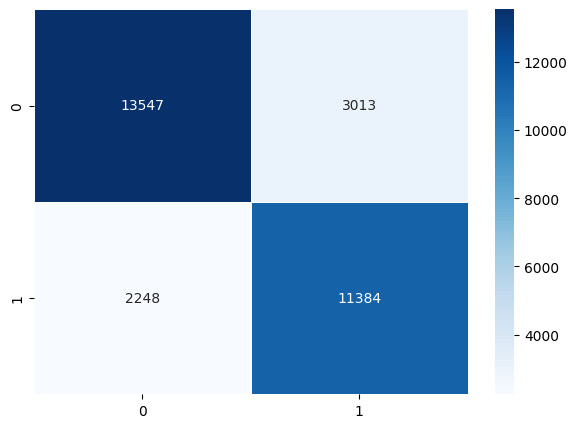

In [183]:
WINDOW = 50

fix_seed(42)

x_train, y_train = make_sequences(train_df, window_size=WINDOW)
x_val, y_val     = make_sequences(val_df, window_size=WINDOW)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_50 = train_model(x_train, y_train, x_val, y_val, A=A)

best_th_50, best_f1 = find_best_threshold(model_50, x_val, y_val)
print("best threshold =", best_th_50)

window_to_model[WINDOW] = model_50
window_to_threshold[WINDOW] = best_th_50

f1, precision, recall, cm = evaluate(model_50, x_val, y_val, threshold=best_th_50)
results.append({
    'Window size': WINDOW,
    'F1-Score': f1,
    'Precision': precision,
    'Recall': recall
})

In [184]:
result_df = pd.DataFrame(results)
result_df

,Window size,F1-Score,Precision,Recall
0,10,0.332486,0.514029,0.245708
1,20,0.405168,0.424925,0.387166
2,30,0.420248,0.270114,0.946107
3,40,0.542964,0.372649,1.000000
4,50,0.812302,0.790720,0.835094


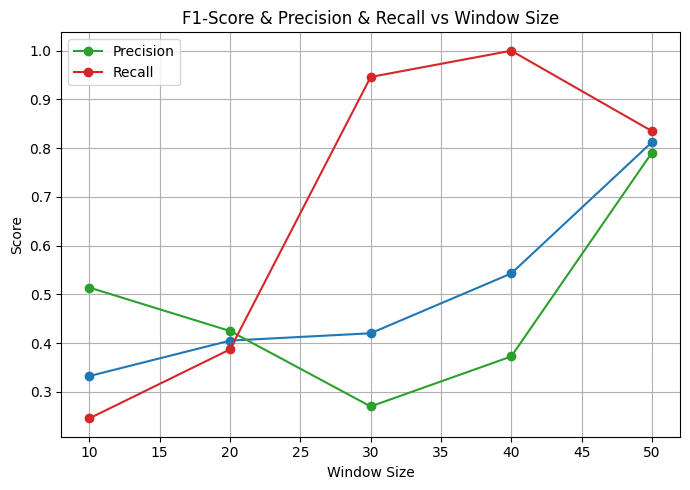

In [185]:
plt.figure(figsize=(7,5))

plt.plot(result_df['Window size'], result_df['F1-Score'], marker='o', color='tab:blue')
plt.plot(result_df['Window size'], result_df['Precision'], marker='o', label='Precision', color='tab:green')
plt.plot(result_df['Window size'], result_df['Recall'], marker='o', label='Recall', color='tab:red')
plt.title('F1-Score & Precision & Recall vs Window Size')
plt.xlabel('Window Size')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import numpy as np

# ------------------------------
# 1️⃣ Focal Loss 정의
# ------------------------------
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, logits, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()


# ------------------------------
# 2️⃣ Oversampling을 위한 sampler 생성
# ------------------------------
def create_sampler(y):
    # y: numpy array
    class_counts = np.bincount(y)
    class_weights = 1. / class_counts
    sample_weights = class_weights[y]
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    return sampler


# ------------------------------
# 3️⃣ 학습 함수 수정
# ------------------------------
def train_model_focal(x, y, x_val, y_val, A, epochs=10, batch_size=64, lr=1e-3):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = STGCN(A.to(device)).to(device)
    loss_fn = FocalLoss()
    optim = torch.optim.Adam(model.parameters(), lr=lr)

    # TensorDataset
    train_ds = TensorDataset(torch.tensor(x).float(), torch.tensor(y).float())
    val_ds = TensorDataset(torch.tensor(x_val).float(), torch.tensor(y_val).float())

    # Weighted sampler for oversampling positive class
    sampler = create_sampler(y)
    train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for seq, label in train_loader:
            seq = seq.to(device)
            label = label.to(device)

            logits = model(seq).view(-1)
            loss = loss_fn(logits, label)

            optim.zero_grad()
            loss.backward()
            optim.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"[Epoch {epoch+1}] loss = {avg_loss:.4f}")

    return model


In [193]:
window_to_model = {}
window_to_threshold = {}
results = []

(377848, 3, 17, 10) (377848,)
[Epoch 1] loss = 0.0302
[Epoch 2] loss = 0.0240
[Epoch 3] loss = 0.0229
[Epoch 4] loss = 0.0225
[Epoch 5] loss = 0.0220
[Epoch 6] loss = 0.0217
[Epoch 7] loss = 0.0213
[Epoch 8] loss = 0.0210
[Epoch 9] loss = 0.0210
[Epoch 10] loss = 0.0207
✅ Best threshold = 0.42363303899765015 Best F1 = 0.1906296915567384

📌 CONFUSION MATRIX
[[ 4478 43802]
 [  389  5203]]

Precision = 0.1062
Recall    = 0.9304
F1        = 0.1906


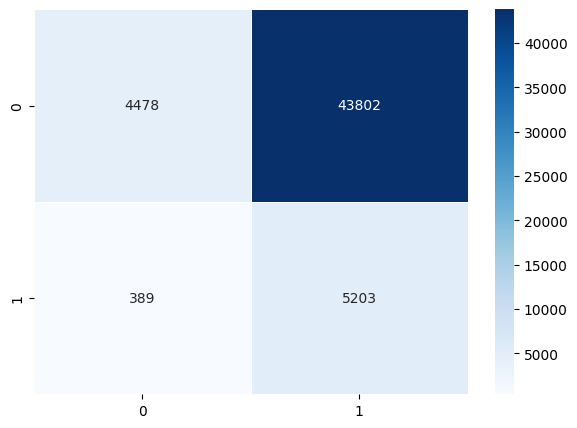

In [194]:
WINDOW = 10
fix_seed(42)

x_train, y_train = make_sequences(train_df, window_size=WINDOW)
x_val, y_val     = make_sequences(val_df, window_size=WINDOW)

print(x_train.shape, y_train.shape)  # sanity check

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model_10 = train_model_focal(x_train, y_train, x_val, y_val, A=A, epochs=10, batch_size=64, lr=1e-3)


best_th_10, best_f1 = find_best_threshold(model_10, x_val, y_val)
print("✅ Best threshold =", best_th_10, "Best F1 =", best_f1)

f1, precision, recall, cm = evaluate(model_10, x_val, y_val, threshold=best_th_10)

window_to_model[WINDOW] = model_10
window_to_threshold[WINDOW] = best_th_10

results.append({
    'Window size': WINDOW,
    'F1-Score': f1,
    'Precision': precision,
    'Recall': recall
})

(336568, 3, 17, 20) (336568,)
[Epoch 1] loss = 0.0314
[Epoch 2] loss = 0.0224
[Epoch 3] loss = 0.0212
[Epoch 4] loss = 0.0203
[Epoch 5] loss = 0.0197
[Epoch 6] loss = 0.0192
[Epoch 7] loss = 0.0187
[Epoch 8] loss = 0.0183
[Epoch 9] loss = 0.0179
[Epoch 10] loss = 0.0177
✅ Best threshold = 0.2881172001361847 Best F1 = 0.44996534132694843

📌 CONFUSION MATRIX
[[33415  6153]
 [ 4165  4219]]

Precision = 0.4068
Recall    = 0.5032
F1        = 0.4499


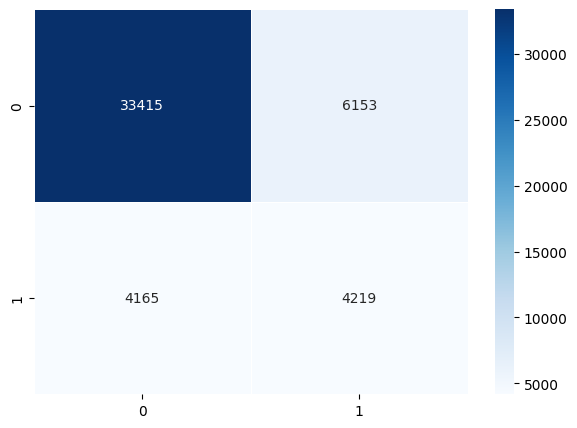

In [195]:
WINDOW = 20
fix_seed(42)

x_train, y_train = make_sequences(train_df, window_size=WINDOW)
x_val, y_val     = make_sequences(val_df, window_size=WINDOW)

print(x_train.shape, y_train.shape)  # sanity check

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model_20 = train_model_focal(x_train, y_train, x_val, y_val, A=A, epochs=10, batch_size=64, lr=1e-3)


best_th_20, best_f1 = find_best_threshold(model_20, x_val, y_val)
print("✅ Best threshold =", best_th_20, "Best F1 =", best_f1)

f1, precision, recall, cm = evaluate(model_20, x_val, y_val, threshold=best_th_20)

window_to_model[WINDOW] = model_20
window_to_threshold[WINDOW] = best_th_20

results.append({
    'Window size': WINDOW,
    'F1-Score': f1,
    'Precision': precision,
    'Recall': recall
})

(295288, 3, 17, 30) (295288,)
[Epoch 1] loss = 0.0314
[Epoch 2] loss = 0.0221
[Epoch 3] loss = 0.0203
[Epoch 4] loss = 0.0192
[Epoch 5] loss = 0.0184
[Epoch 6] loss = 0.0179
[Epoch 7] loss = 0.0171
[Epoch 8] loss = 0.0167
[Epoch 9] loss = 0.0161
[Epoch 10] loss = 0.0158
✅ Best threshold = 0.48897114396095276 Best F1 = 0.4178435548609969

📌 CONFUSION MATRIX
[[   21 30915]
 [    2 11094]]

Precision = 0.2641
Recall    = 0.9998
F1        = 0.4178


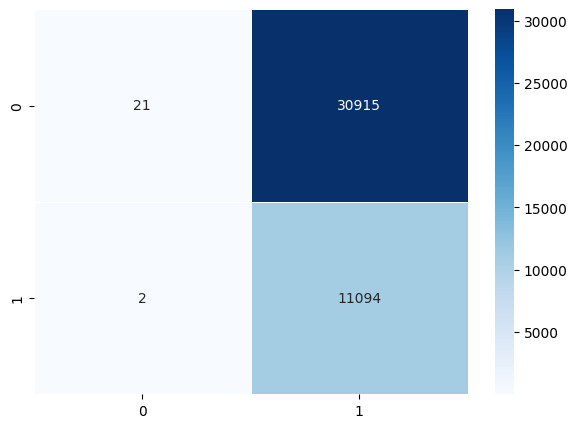

In [196]:
WINDOW = 30
fix_seed(42)

x_train, y_train = make_sequences(train_df, window_size=WINDOW)
x_val, y_val     = make_sequences(val_df, window_size=WINDOW)

print(x_train.shape, y_train.shape)  # sanity check

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model_30 = train_model_focal(x_train, y_train, x_val, y_val, A=A, epochs=10, batch_size=64, lr=1e-3)


best_th_30, best_f1 = find_best_threshold(model_30, x_val, y_val)
print("✅ Best threshold =", best_th_30, "Best F1 =", best_f1)

f1, precision, recall, cm = evaluate(model_30, x_val, y_val, threshold=best_th_30)

window_to_model[WINDOW] = model_30
window_to_threshold[WINDOW] = best_th_30

results.append({
    'Window size': WINDOW,
    'F1-Score': f1,
    'Precision': precision,
    'Recall': recall
})

(254008, 3, 17, 40) (254008,)
[Epoch 1] loss = 0.0323
[Epoch 2] loss = 0.0216
[Epoch 3] loss = 0.0194
[Epoch 4] loss = 0.0183
[Epoch 5] loss = 0.0177
[Epoch 6] loss = 0.0169
[Epoch 7] loss = 0.0164
[Epoch 8] loss = 0.0160
[Epoch 9] loss = 0.0153
[Epoch 10] loss = 0.0149
✅ Best threshold = 0.27271825075149536 Best F1 = 0.5429309192208035

📌 CONFUSION MATRIX
[[    0 22656]
 [    1 13455]]

Precision = 0.3726
Recall    = 0.9999
F1        = 0.5429


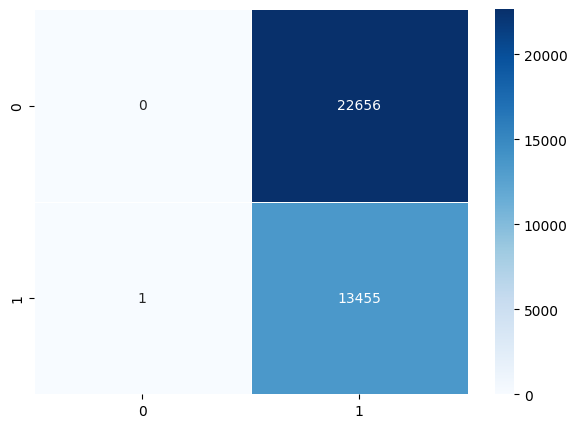

In [197]:
WINDOW = 40
fix_seed(42)

x_train, y_train = make_sequences(train_df, window_size=WINDOW)
x_val, y_val     = make_sequences(val_df, window_size=WINDOW)

print(x_train.shape, y_train.shape)  # sanity check

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model_40 = train_model_focal(x_train, y_train, x_val, y_val, A=A, epochs=10, batch_size=64, lr=1e-3)


best_th_40, best_f1 = find_best_threshold(model_40, x_val, y_val)
print("✅ Best threshold =", best_th_40, "Best F1 =", best_f1)

f1, precision, recall, cm = evaluate(model_40, x_val, y_val, threshold=best_th_40)

window_to_model[WINDOW] = model_40
window_to_threshold[WINDOW] = best_th_40

results.append({
    'Window size': WINDOW,
    'F1-Score': f1,
    'Precision': precision,
    'Recall': recall
})

(212728, 3, 17, 50) (212728,)
[Epoch 1] loss = 0.0300
[Epoch 2] loss = 0.0181
[Epoch 3] loss = 0.0152
[Epoch 4] loss = 0.0140
[Epoch 5] loss = 0.0132
[Epoch 6] loss = 0.0122
[Epoch 7] loss = 0.0115
[Epoch 8] loss = 0.0110
[Epoch 9] loss = 0.0104
[Epoch 10] loss = 0.0099
✅ Best threshold = 0.23972821235656738 Best F1 = 0.6390488528965267

📌 CONFUSION MATRIX
[[ 4551 12009]
 [ 1593 12039]]

Precision = 0.5006
Recall    = 0.8831
F1        = 0.6390


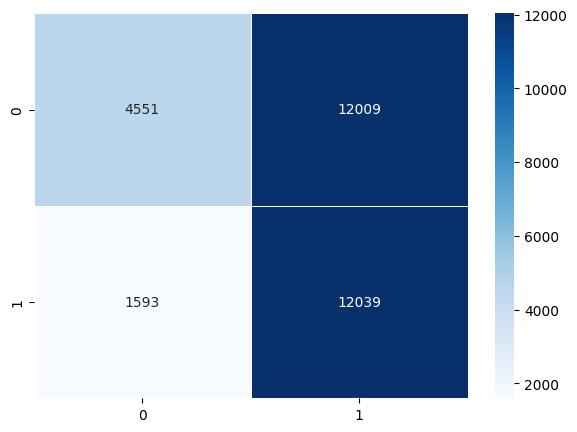

In [198]:
WINDOW = 50
fix_seed(42)

x_train, y_train = make_sequences(train_df, window_size=WINDOW)
x_val, y_val     = make_sequences(val_df, window_size=WINDOW)

print(x_train.shape, y_train.shape)  # sanity check

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model_50 = train_model_focal(x_train, y_train, x_val, y_val, A=A, epochs=10, batch_size=64, lr=1e-3)


best_th_50, best_f1 = find_best_threshold(model_50, x_val, y_val)
print("✅ Best threshold =", best_th_50, "Best F1 =", best_f1)

f1, precision, recall, cm = evaluate(model_50, x_val, y_val, threshold=best_th_50)

window_to_model[WINDOW] = model_50
window_to_threshold[WINDOW] = best_th_50

results.append({
    'Window size': WINDOW,
    'F1-Score': f1,
    'Precision': precision,
    'Recall': recall
})

In [199]:
result_df = pd.DataFrame(results)
result_df

,Window size,F1-Score,Precision,Recall
0,10,0.190597,0.106173,0.930436
1,20,0.449883,0.406768,0.503220
2,30,0.417814,0.264086,0.999820
3,40,0.542902,0.372601,0.999926
4,50,0.639013,0.500624,0.883143


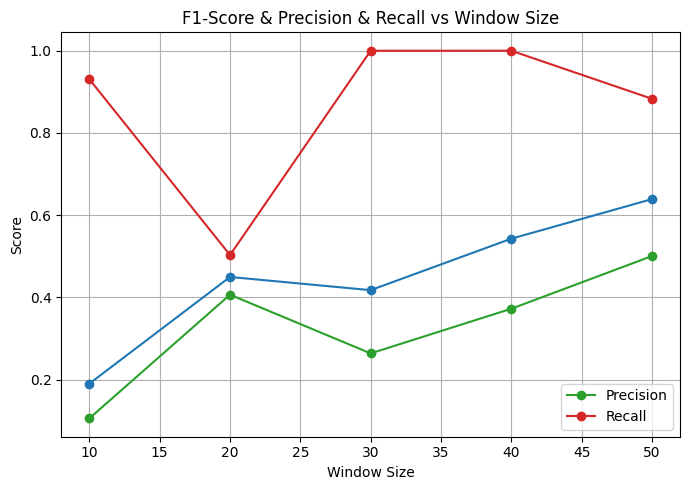

In [200]:
plt.figure(figsize=(7,5))

plt.plot(result_df['Window size'], result_df['F1-Score'], marker='o', color='tab:blue')
plt.plot(result_df['Window size'], result_df['Precision'], marker='o', label='Precision', color='tab:green')
plt.plot(result_df['Window size'], result_df['Recall'], marker='o', label='Recall', color='tab:red')
plt.title('F1-Score & Precision & Recall vs Window Size')
plt.xlabel('Window Size')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [25]:
def make_sequences(df, window_size=10, step=1):
    x, y = [], []

    joint_count = 17
    channels = 3  # x,y,score

    feature_cols = []
    for j in range(joint_count):
        for c in ["x","y","score"]:
            feature_cols.append(f"{j}_{c}")

    # rename raw data → 0_x, 0_y, 0_score, ...
    rename_map = {}
    k = 0
    for i, joint in enumerate([
        "nose","left_eye","right_eye",
        "left_ear","right_ear",
        "left_shoulder","right_shoulder",
        "left_elbow","right_elbow",
        "left_wrist","right_wrist",
        "left_hip","right_hip",
        "left_knee","right_knee",
        "left_ankle","right_ankle",
    ]):
        rename_map[f"{joint}_x"] = f"{i}_x"
        rename_map[f"{joint}_y"] = f"{i}_y"
        rename_map[f"{joint}_score"] = f"{i}_score"

    df = df.rename(columns=rename_map)

    for file, group in df.groupby("file"):
        labels = group["label"].values
        data = group[feature_cols].values.reshape(-1, joint_count, channels)

        for i in range(0, len(data)-window_size+1, step):
            seq = data[i:i+window_size]              # (T, 17, 3)
            seq = np.transpose(seq, (2,1,0))         # (3,17,T)

            target = 1 if np.mean(labels[i:i+window_size]) > 0.2 else 0
            x.append(seq)
            y.append(target)

    x = np.array(x)
    y = np.array(y)

    return x, y

In [26]:
window_to_model = {}
window_to_threshold = {}
results = []

(377848, 3, 17, 10) (377848,)
[Epoch 1] loss = 0.0263
[Epoch 2] loss = 0.0192
[Epoch 3] loss = 0.0182
[Epoch 4] loss = 0.0177
[Epoch 5] loss = 0.0173
[Epoch 6] loss = 0.0170
[Epoch 7] loss = 0.0165
[Epoch 8] loss = 0.0161
[Epoch 9] loss = 0.0159
[Epoch 10] loss = 0.0156
✅ Best threshold = 0.6536781787872314 Best F1 = 0.337969225820034

📌 CONFUSION MATRIX
[[47120  2280]
 [ 3100  1372]]

Precision = 0.3757
Recall    = 0.3068
F1        = 0.3378


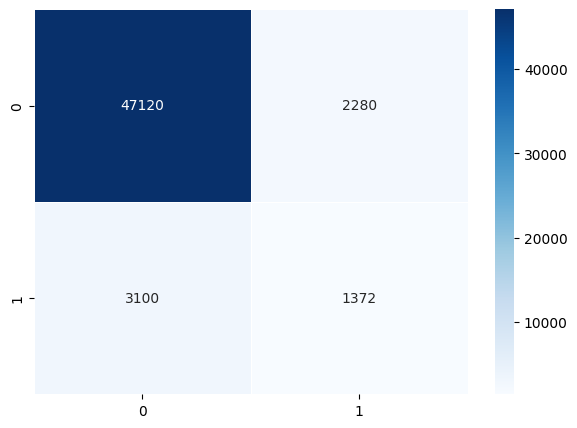

In [27]:
WINDOW = 10
fix_seed(42)

x_train, y_train = make_sequences(train_df, window_size=WINDOW)
x_val, y_val     = make_sequences(val_df, window_size=WINDOW)

print(x_train.shape, y_train.shape)  # sanity check

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model_10 = train_model_focal(x_train, y_train, x_val, y_val, A=A, epochs=10, batch_size=64, lr=1e-3)


best_th_10, best_f1 = find_best_threshold(model_10, x_val, y_val)
print("✅ Best threshold =", best_th_10, "Best F1 =", best_f1)

f1, precision, recall, cm = evaluate(model_10, x_val, y_val, threshold=best_th_10)

window_to_model[WINDOW] = model_10
window_to_threshold[WINDOW] = best_th_10

results.append({
    'Window size': WINDOW,
    'F1-Score': f1,
    'Precision': precision,
    'Recall': recall
})

(336568, 3, 17, 20) (336568,)
[Epoch 1] loss = 0.0238
[Epoch 2] loss = 0.0154
[Epoch 3] loss = 0.0140
[Epoch 4] loss = 0.0132
[Epoch 5] loss = 0.0125
[Epoch 6] loss = 0.0120
[Epoch 7] loss = 0.0115
[Epoch 8] loss = 0.0112
[Epoch 9] loss = 0.0107
[Epoch 10] loss = 0.0105
✅ Best threshold = 0.549045979976654 Best F1 = 0.3578423003229168

📌 CONFUSION MATRIX
[[33447  8353]
 [ 2992  3160]]

Precision = 0.2745
Recall    = 0.5137
F1        = 0.3578


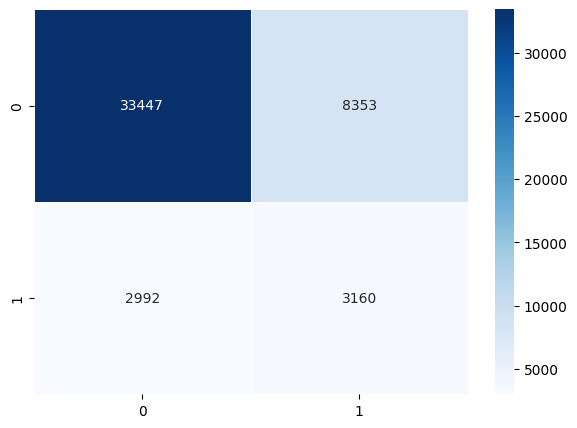

In [28]:
WINDOW = 20
fix_seed(42)

x_train, y_train = make_sequences(train_df, window_size=WINDOW)
x_val, y_val     = make_sequences(val_df, window_size=WINDOW)

print(x_train.shape, y_train.shape)  # sanity check

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model_20 = train_model_focal(x_train, y_train, x_val, y_val, A=A, epochs=10, batch_size=64, lr=1e-3)


best_th_20, best_f1 = find_best_threshold(model_20, x_val, y_val)
print("✅ Best threshold =", best_th_20, "Best F1 =", best_f1)

f1, precision, recall, cm = evaluate(model_20, x_val, y_val, threshold=best_th_20)

window_to_model[WINDOW] = model_20
window_to_threshold[WINDOW] = best_th_20

results.append({
    'Window size': WINDOW,
    'F1-Score': f1,
    'Precision': precision,
    'Recall': recall
})

(295288, 3, 17, 30) (295288,)
[Epoch 1] loss = 0.0232
[Epoch 2] loss = 0.0144
[Epoch 3] loss = 0.0125
[Epoch 4] loss = 0.0113
[Epoch 5] loss = 0.0105
[Epoch 6] loss = 0.0096
[Epoch 7] loss = 0.0091
[Epoch 8] loss = 0.0084
[Epoch 9] loss = 0.0080
[Epoch 10] loss = 0.0077
✅ Best threshold = 0.39764735102653503 Best F1 = 0.3740140187154399

📌 CONFUSION MATRIX
[[19769 14471]
 [ 2672  5120]]

Precision = 0.2613
Recall    = 0.6571
F1        = 0.3740


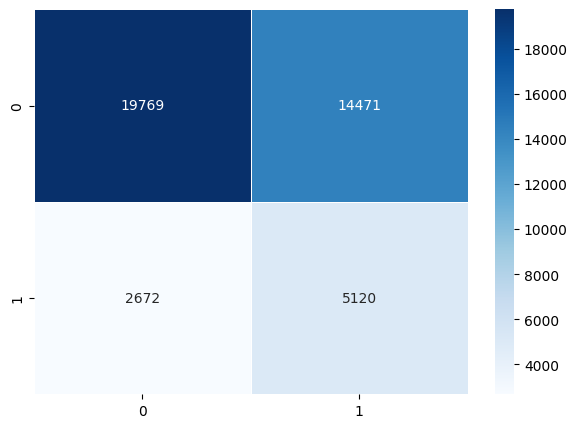

In [29]:
WINDOW = 30
fix_seed(42)

x_train, y_train = make_sequences(train_df, window_size=WINDOW)
x_val, y_val     = make_sequences(val_df, window_size=WINDOW)

print(x_train.shape, y_train.shape)  # sanity check

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model_30 = train_model_focal(x_train, y_train, x_val, y_val, A=A, epochs=10, batch_size=64, lr=1e-3)


best_th_30, best_f1 = find_best_threshold(model_30, x_val, y_val)
print("✅ Best threshold =", best_th_30, "Best F1 =", best_f1)

f1, precision, recall, cm = evaluate(model_30, x_val, y_val, threshold=best_th_30)

window_to_model[WINDOW] = model_30
window_to_threshold[WINDOW] = best_th_30

results.append({
    'Window size': WINDOW,
    'F1-Score': f1,
    'Precision': precision,
    'Recall': recall
})

(254008, 3, 17, 40) (254008,)
[Epoch 1] loss = 0.0259
[Epoch 2] loss = 0.0152
[Epoch 3] loss = 0.0131
[Epoch 4] loss = 0.0121
[Epoch 5] loss = 0.0114
[Epoch 6] loss = 0.0108
[Epoch 7] loss = 0.0102
[Epoch 8] loss = 0.0097
[Epoch 9] loss = 0.0093
[Epoch 10] loss = 0.0089
✅ Best threshold = 0.23496243357658386 Best F1 = 0.41251977868451856

📌 CONFUSION MATRIX
[[    0 26728]
 [    1  9383]]

Precision = 0.2598
Recall    = 0.9999
F1        = 0.4125


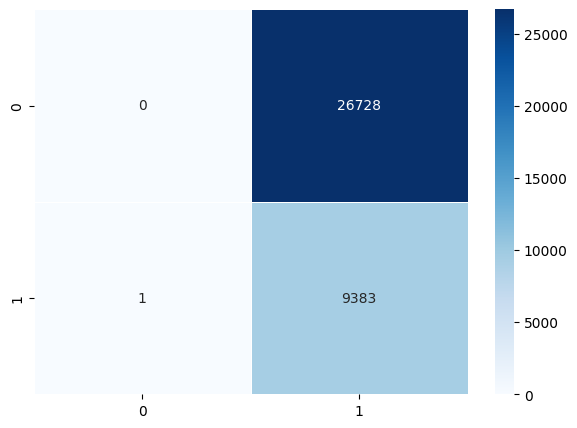

In [30]:
WINDOW = 40
fix_seed(42)

x_train, y_train = make_sequences(train_df, window_size=WINDOW)
x_val, y_val     = make_sequences(val_df, window_size=WINDOW)

print(x_train.shape, y_train.shape)  # sanity check

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model_40 = train_model_focal(x_train, y_train, x_val, y_val, A=A, epochs=10, batch_size=64, lr=1e-3)


best_th_40, best_f1 = find_best_threshold(model_40, x_val, y_val)
print("✅ Best threshold =", best_th_40, "Best F1 =", best_f1)

f1, precision, recall, cm = evaluate(model_40, x_val, y_val, threshold=best_th_40)

window_to_model[WINDOW] = model_40
window_to_threshold[WINDOW] = best_th_40

results.append({
    'Window size': WINDOW,
    'F1-Score': f1,
    'Precision': precision,
    'Recall': recall
})

(212728, 3, 17, 50) (212728,)
[Epoch 1] loss = 0.0289
[Epoch 2] loss = 0.0163
[Epoch 3] loss = 0.0138
[Epoch 4] loss = 0.0127
[Epoch 5] loss = 0.0119
[Epoch 6] loss = 0.0111
[Epoch 7] loss = 0.0107
[Epoch 8] loss = 0.0102
[Epoch 9] loss = 0.0097
[Epoch 10] loss = 0.0095
✅ Best threshold = 0.14545325934886932 Best F1 = 0.5104996877464797

📌 CONFUSION MATRIX
[[   11 19837]
 [    1 10343]]

Precision = 0.3427
Recall    = 0.9999
F1        = 0.5105


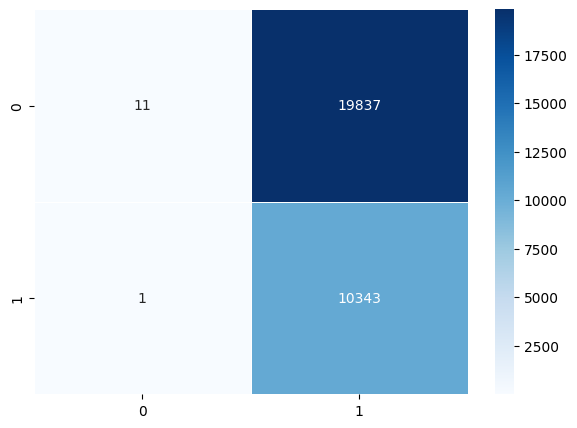

In [31]:
WINDOW = 50
fix_seed(42)

x_train, y_train = make_sequences(train_df, window_size=WINDOW)
x_val, y_val     = make_sequences(val_df, window_size=WINDOW)

print(x_train.shape, y_train.shape)  # sanity check

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model_50 = train_model_focal(x_train, y_train, x_val, y_val, A=A, epochs=10, batch_size=64, lr=1e-3)


best_th_50, best_f1 = find_best_threshold(model_50, x_val, y_val)
print("✅ Best threshold =", best_th_50, "Best F1 =", best_f1)

f1, precision, recall, cm = evaluate(model_50, x_val, y_val, threshold=best_th_50)

window_to_model[WINDOW] = model_50
window_to_threshold[WINDOW] = best_th_50

results.append({
    'Window size': WINDOW,
    'F1-Score': f1,
    'Precision': precision,
    'Recall': recall
})

In [32]:
result_df = pd.DataFrame(results)
result_df

,Window size,F1-Score,Precision,Recall
0,10,0.337765,0.375685,0.306798
1,20,0.357770,0.274472,0.513654
2,30,0.373955,0.261344,0.657084
3,40,0.412485,0.259838,0.999893
4,50,0.510463,0.342710,0.999903


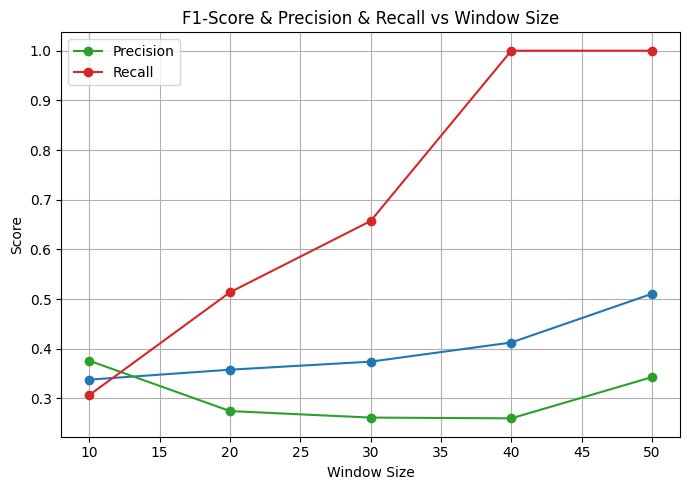

In [33]:
plt.figure(figsize=(7,5))

plt.plot(result_df['Window size'], result_df['F1-Score'], marker='o', color='tab:blue')
plt.plot(result_df['Window size'], result_df['Precision'], marker='o', label='Precision', color='tab:green')
plt.plot(result_df['Window size'], result_df['Recall'], marker='o', label='Recall', color='tab:red')
plt.title('F1-Score & Precision & Recall vs Window Size')
plt.xlabel('Window Size')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

아요, 이 부분은 모델 구조와 데이터 특성을 같이 봐야 이해가 됩니다. 😅

1️⃣ ST-GCN의 장점

ST-GCN은 공간적 연결과 시간적 변화를 동시에 모델링합니다.

관절 데이터에서는 관절 간 연결 구조(예: 팔꿈치는 어깨와 손목과 연결) 정보를 활용할 수 있음.

즉, CNN 기반의 GCN으로 관절 간 관계를 명시적으로 학습할 수 있습니다.

2️⃣ 그런데 왜 성능이 LSTM보다 안 나올까?

여러 원인이 있습니다:

데이터 희소/불균형 문제

지금 데이터는 이벤트(1) 발생 비율이 매우 낮음 → target=1 비율이 낮음.

ST-GCN은 구조적 학습에 강하지만, 불균형 라벨 학습에는 약함.

LSTM은 단순 sequence modeling이라 작은 positive signal도 반복 학습 가능.

윈도우 크기와 temporal pooling

현재 코드에서는 x.mean(dim=[2,3])로 spatial+temporal pooling 후 fc layer에 전달.

긴 시퀀스에서는 시간 정보가 많이 날아감 → 이벤트 패턴이 희미해짐.

LSTM은 시간 순서 정보를 유지하면서 학습하기 때문에, 희미한 패턴도 포착 가능.

데이터 수량 vs 모델 복잡도

ST-GCN은 parameter 수가 많음 → 충분한 학습 데이터가 없으면 과적합.

반면 LSTM은 구조가 단순 → 작은 데이터에서도 패턴 학습 가능.

Graph 구조의 제한

현재 ST-GCN은 COCO 17 관절 그래프 그대로 사용.

실제 데이터 이벤트가 COCO 그래프 관계와 강하게 연관되지 않으면, GCN 장점이 제한됨.

LSTM은 graph 구조를 사용하지 않으므로, “단순 sequence 패턴”에 바로 반응 가능.

3️⃣ 해결 방안

라벨 imbalance 처리 강화

Weighted loss (BCEWithLogitsLoss pos_weight)

Focal Loss

윈도우 크기, stride 조정

너무 큰 window → 이벤트 희석

Graph 구조 튜닝

실험적으로 adjacency matrix 수정 (중요 관절만 연결)

Hybrid 모델

ST-GCN → LSTM → fc layer

ST-GCN로 공간 정보 추출 후, LSTM으로 시간 패턴 학습

즉, ST-GCN이 관절 데이터에 강한 건 맞지만 라벨 불균형, 이벤트 희소, 시간 pooling 방식 때문에 지금 데이터에서는 오히려 LSTM이 유리할 수 있습니다.

아요, 이 부분은 모델 구조와 데이터 특성을 같이 봐야 이해가 됩니다. 😅

1️⃣ ST-GCN의 장점

ST-GCN은 공간적 연결과 시간적 변화를 동시에 모델링합니다.

관절 데이터에서는 관절 간 연결 구조(예: 팔꿈치는 어깨와 손목과 연결) 정보를 활용할 수 있음.

즉, CNN 기반의 GCN으로 관절 간 관계를 명시적으로 학습할 수 있습니다.

2️⃣ 그런데 왜 성능이 LSTM보다 안 나올까?

여러 원인이 있습니다:

데이터 희소/불균형 문제

지금 데이터는 이벤트(1) 발생 비율이 매우 낮음 → target=1 비율이 낮음.

ST-GCN은 구조적 학습에 강하지만, 불균형 라벨 학습에는 약함.

LSTM은 단순 sequence modeling이라 작은 positive signal도 반복 학습 가능.

윈도우 크기와 temporal pooling

현재 코드에서는 x.mean(dim=[2,3])로 spatial+temporal pooling 후 fc layer에 전달.

긴 시퀀스에서는 시간 정보가 많이 날아감 → 이벤트 패턴이 희미해짐.

LSTM은 시간 순서 정보를 유지하면서 학습하기 때문에, 희미한 패턴도 포착 가능.

데이터 수량 vs 모델 복잡도

ST-GCN은 parameter 수가 많음 → 충분한 학습 데이터가 없으면 과적합.

반면 LSTM은 구조가 단순 → 작은 데이터에서도 패턴 학습 가능.

Graph 구조의 제한

현재 ST-GCN은 COCO 17 관절 그래프 그대로 사용.

실제 데이터 이벤트가 COCO 그래프 관계와 강하게 연관되지 않으면, GCN 장점이 제한됨.

LSTM은 graph 구조를 사용하지 않으므로, “단순 sequence 패턴”에 바로 반응 가능.

3️⃣ 해결 방안

라벨 imbalance 처리 강화

Weighted loss (BCEWithLogitsLoss pos_weight)

Focal Loss

윈도우 크기, stride 조정

너무 큰 window → 이벤트 희석

Graph 구조 튜닝

실험적으로 adjacency matrix 수정 (중요 관절만 연결)

Hybrid 모델

ST-GCN → LSTM → fc layer

ST-GCN로 공간 정보 추출 후, LSTM으로 시간 패턴 학습

즉, ST-GCN이 관절 데이터에 강한 건 맞지만 라벨 불균형, 이벤트 희소, 시간 pooling 방식 때문에 지금 데이터에서는 오히려 LSTM이 유리할 수 있습니다.